# Machine Learning Module Practice Case

On this week's module practice case, we are require to solve some machine learning use cases. Here are the cases:

Suppose that you are working in a consulting company. You meet a client who is interested in implementing a data science project for the first time to solve their problem. You are provided with some problems to be solved, just to examine your capabilities: 


Here are the options of problems for you to solve:

1. Home Credit Default Risk: https://www.kaggle.com/c/home-credit-default-risk/data<br>
2. House price prediction: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data<br>
3. Supermarket: https://www.kaggle.com/mahmoudeletrby/supermarket<br>
4. Customer Segmentation and Market Basket Analysis: https://www.kaggle.com/mgmarques/customer-segmentation-and-market-basket-analysis/data<br>
5. Product classification: https://www.kaggle.com/lakritidis/product-classification-and-categorization<br>

Please select one of the cases above and make your machine learning model. Do not forget to implement CRISP-DM steps! Please be creative and hopefully, you can implement the best coding practices in your code.

For my case, I chose the House Price Prediction with Linear Regression.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

from scipy import stats

import category_encoders as ce
import statsmodels.api as sm

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.shape

(1460, 81)

In [5]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We need to delete the 'Id' column, because it is not required in the model that we will build. 

In [7]:
# Deleting 'Id' column
del data['Id']

## Normality Check

[]

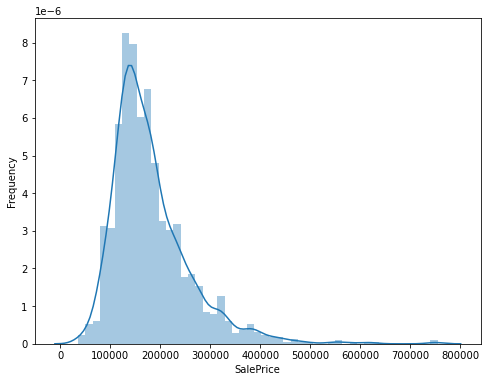

In [8]:
plt.subplots(figsize = (8,6))
sns.distplot(data['SalePrice'])
plt.ylabel('Frequency')
plt.plot()

[]

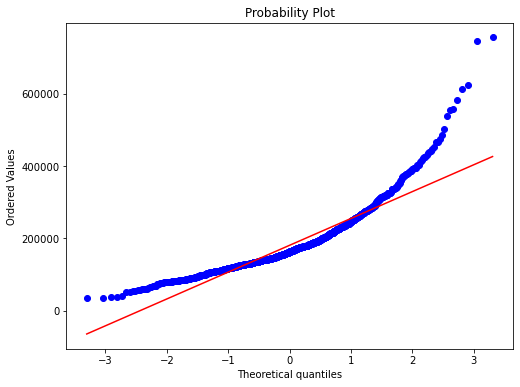

In [9]:
plt.subplots(figsize = (8,6))
stats.probplot(data['SalePrice'], plot = plt)
plt.plot()

The target variable is positively skewed, so we will try to apply log transform and hopefully we will get a normally-distributed target variable.

[]

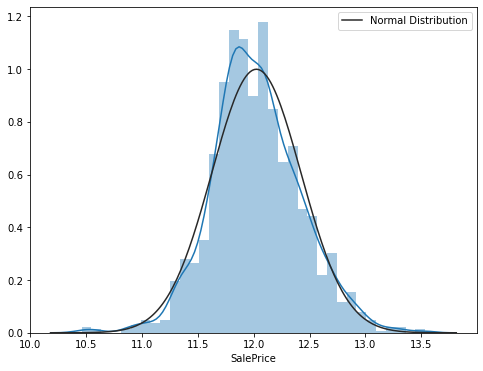

In [10]:
data['SalePrice'] = np.log1p(data['SalePrice'])

plt.subplots(figsize = (8,6))
sns.distplot(data['SalePrice'], fit = stats.norm)
plt.legend(['Normal Distribution'])
plt.plot()

[]

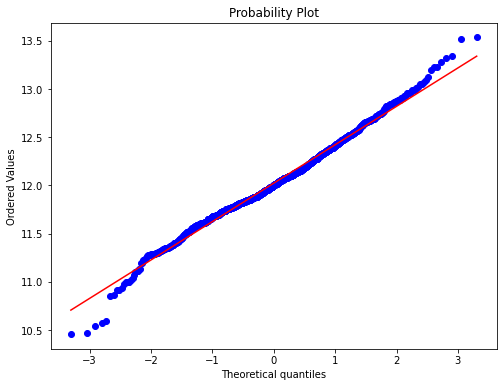

In [11]:
plt.subplots(figsize = (8,6))
stats.probplot(data['SalePrice'], plot = plt)
plt.plot()

After applying log transform to the target variabel, we achieved a normally-distributed target variable.

## Missing Values Handling

In [12]:
#Calculating missing values percentage
null_pct = round(data.isna().mean()*100, 2).sort_values(ascending = False)
null_pct = null_pct[null_pct > 0]
null_pct

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageType       5.55
GarageCond       5.55
GarageFinish     5.55
GarageQual       5.55
GarageYrBlt      5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtQual         2.53
BsmtCond         2.53
BsmtFinType1     2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

As we can see, the **'PoolQC', 'MiscFeature', 'Alley', and 'Fence'** variable have **more than 70% missing values**, so we need to **drop them**.

In [13]:
#Dropping columns with more than 70% missing values
data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1, inplace = True)

The rest of the variables are below 70% in terms of missing values percentage. We can handle all those missing values in 2 ways:

**1. Imputing categorical variable missing values with its mode.**<br>
**2. Imputing numerical variable missing values with its median.**
  
So, first we need to check the data type of each variable.

In [14]:
# Checking data type of each variable
data[['FireplaceQu', 'LotFrontage', 'GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'BsmtExposure',
    'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrArea', 'MasVnrType', 'Electrical']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FireplaceQu   770 non-null    object 
 1   LotFrontage   1201 non-null   float64
 2   GarageCond    1379 non-null   object 
 3   GarageType    1379 non-null   object 
 4   GarageYrBlt   1379 non-null   float64
 5   GarageFinish  1379 non-null   object 
 6   GarageQual    1379 non-null   object 
 7   BsmtExposure  1422 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   BsmtFinType1  1423 non-null   object 
 10  BsmtCond      1423 non-null   object 
 11  BsmtQual      1423 non-null   object 
 12  MasVnrArea    1452 non-null   float64
 13  MasVnrType    1452 non-null   object 
 14  Electrical    1459 non-null   object 
dtypes: float64(3), object(12)
memory usage: 171.2+ KB


After knowing the data type of each variable, we can now impute the missing values.

In [15]:
#Imputing categorical missing values with their mode
missing_cat = data[['FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtExposure', 
                    'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrType', 'Electrical']]

for col in missing_cat:
    data[col].fillna(data[col].mode()[0], inplace = True)

#Imputing numerical missing values with their median
missing_num = data[['LotFrontage', 'GarageYrBlt', 'MasVnrArea']]

for col in missing_num:
    data[col].fillna(data[col].median(), inplace = True)

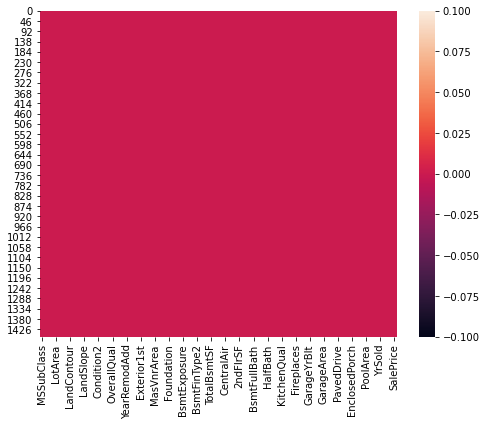

In [16]:
#Calculating missing values percentage one more time
plt.subplots(figsize = (8,6))
sns.heatmap(data.isna())
plt.show()

Now, there is no missing value in our dataset.

## Encoding Categorical Variables

There are 2 types of categorical variable in our dataset: ordinal and nominal. We need to encode them first before we jump into the modelling part.

We will use the **OrdinalEncoder** library to encode our ordinal variables. Here are the ordinal variables which are categorical variables that have ranks in our dataset:

In [17]:
#Selecting ordinal variables 
ordinal_var = data[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
                    'FireplaceQu', 'GarageQual', 'GarageCond']]

ordinal_var.head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond
0,Gd,TA,Gd,TA,Ex,Gd,Gd,TA,TA
1,TA,TA,Gd,TA,Ex,TA,TA,TA,TA
2,Gd,TA,Gd,TA,Ex,Gd,TA,TA,TA
3,TA,TA,TA,Gd,Gd,Gd,Gd,TA,TA
4,Gd,TA,Gd,TA,Ex,Gd,TA,TA,TA


We will encode our ordinal variables by this conditions:

1. **'Ex'** (Excellent): 4
2. **'Gd'** (Good): 3
3. **'TA'** (Typical/Average): 2
4. **'Fa'** (Fair): 1
5. **'Po'** (Poor): 0

In [18]:
#Encoding ordinal variables
for col in ordinal_var:
    qual_map = [
        {'col' : col,
         'mapping' : {
             'Ex' : 4,
             'Gd' : 3,
             'TA' : 2,
             'Fa' : 1,
             'Po' : 0,
         }}
    ]
    
    enc = ce.OrdinalEncoder(mapping = qual_map, return_df = True)
    data[col] = enc.fit_transform(data[col])

In [19]:
# Checking encoded ordinal variables
data[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
      'FireplaceQu','GarageQual', 'GarageCond']].head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond
0,3,2,3,2,4,3,3,2,2
1,2,2,3,2,4,2,2,2,2
2,3,2,3,2,4,3,2,2,2
3,2,2,2,3,3,3,3,2,2
4,3,2,3,2,4,3,2,2,2


Now, after encoding our ordinal variables, we are now left with nominal variables which still have 'object' as their data type. To select the nominal variables, we can simply select the variables which have 'object' as their data type.

In [20]:
# Selecting nominal variables
nominal_var = data.select_dtypes(include = ['object'])
nominal_var.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,BsmtFinType2,Heating,CentralAir,Electrical,Functional,GarageType,GarageFinish,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Unf,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Unf,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Unf,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Unf,GasA,Y,SBrkr,Typ,Detchd,Unf,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Unf,GasA,Y,SBrkr,Typ,Attchd,RFn,Y,WD,Normal


We will use **LabelEncoder** from sklearn library to encode our nominal variables.

In [21]:
le = LabelEncoder()

for col in nominal_var:
    data[col] = le.fit_transform(data[col])

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int32  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int32  
 5   LotShape       1460 non-null   int32  
 6   LandContour    1460 non-null   int32  
 7   Utilities      1460 non-null   int32  
 8   LotConfig      1460 non-null   int32  
 9   LandSlope      1460 non-null   int32  
 10  Neighborhood   1460 non-null   int32  
 11  Condition1     1460 non-null   int32  
 12  Condition2     1460 non-null   int32  
 13  BldgType       1460 non-null   int32  
 14  HouseStyle     1460 non-null   int32  
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

As we can see, now we are all have all-numeric dataset.

## Correlation Check

In [23]:
data.corr()['SalePrice'].abs().sort_values(ascending = False).head(12)

SalePrice      1.000000
OverallQual    0.817185
GrLivArea      0.700927
GarageCars     0.680625
ExterQual      0.678840
KitchenQual    0.667893
BsmtQual       0.657131
GarageArea     0.650888
TotalBsmtSF    0.612134
1stFlrSF       0.596981
FullBath       0.594771
YearBuilt      0.586570
Name: SalePrice, dtype: float64

## Preparing The Data for Modelling

Target variable: 'SalePrice'<br>
Predictor/feature variables: all variables except 'SalePrice'

In [24]:
y = data['SalePrice']

X = data.drop(['SalePrice'], axis = 1)

Train data: 80% from the whole dataset<br>
Test data: 20% from the whole dataset

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Linear Regression with sklearn

In [27]:
# Train the model
reg = LinearRegression()

reg.fit(X_train, y_train)

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 20.747147239252726
Coefficients: 
 [-2.17209595e-04 -9.20784032e-03 -4.13333113e-04  1.53344183e-06
  1.58120656e-01 -6.59193031e-03 -2.23368686e-06 -1.64116008e-01
 -8.08800945e-04  2.03336678e-02  1.00998918e-03  6.25202665e-03
 -7.38333437e-03 -1.53246964e-02 -7.60741060e-03  6.80314503e-02
  3.64330957e-02  1.55571377e-03  6.00827275e-04  4.46675153e-03
  1.02180779e-02 -6.02080239e-03  3.56511158e-03  1.09605111e-02
  1.53871121e-05  1.72433054e-02 -1.31585672e-02  1.59438543e-02
  3.30371830e-02  1.14782859e-03 -1.11780757e-02 -8.52161918e-03
 -5.33591214e-06  1.33488440e-02  5.65502131e-05 -1.31226928e-05
  3.80916089e-05 -2.78404771e-03  1.33830335e-02  9.76331751e-02
 -5.29224421e-04  7.55727664e-05  4.39544380e-05  2.93108639e-05
  1.48838068e-04  5.32095094e-02  2.85358198e-02  4.56000611e-02
  2.62802345e-02 -5.73287153e-03 -3.89916125e-02  2.69400221e-02
  1.18360895e-02  1.87283030e-02  2.78578004e-02  5.27633541e-03
 -3.91983005e-03 -9.41894470e-04 -7.734160

In [28]:
# Train score
reg.score(X_train, y_train)

0.8871426866410173

In [29]:
# Test score
reg.score(X_test, y_test)

0.8731709483187664

## Linear Regression with statsmodel

In [30]:
X = sm.add_constant(X_train)
est = sm.OLS(y_train, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     117.8
Date:                Sun, 30 Aug 2020   Prob (F-statistic):               0.00
Time:                        17:58:43   Log-Likelihood:                 692.88
No. Observations:                1168   AIC:                            -1238.
Df Residuals:                    1094   BIC:                            -863.1
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            20.7471      6.529      3.178

From the both modelling process above, we could achieve a linear regression model with 0.887 R-squared score, which means our model is high in accuracy.